In [1]:
!pip install --upgrade tf_slim

import gym
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tf_slim as slim
import numpy.random as rnd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
from collections import deque # container em forma de lista, com rapida insercao e remocao nas duas extremidades 
from ns3gym import ns3env

#from sklearn.preprocessing import label_binarize
#from keras.layers import Dense, Flatten, Reshape

/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sheila/anaconda3/envs/environment_py3_7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sheila/

In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_random_seed(seed)#tf.random.set_seed(seed)
random.seed(seed)

In [3]:
env = gym.make('ns3-v0') # environment ID 

# numero de estados
state_size = env.observation_space.shape[0]

# numero de acoes
action_size = env.action_space.n

print("\n")
print("Numero de Estados: ", state_size)
print("Numero de Acoes: ", action_size) 

Got new port for ns3gm interface:  5913
Build ns-3 project if required
Waf: Entering directory `/home/sheila/Downloads/ns3-gym-master/build'
[1832/1883] Compiling scratch/interference-pattern/mygym.cc
[1834/1883] Linking build/scratch/interference-pattern/interference-pattern
Waf: Leaving directory `/home/sheila/Downloads/ns3-gym-master/build'


Numero de Estados:  4
Numero de Acoes:  4


In [4]:
numOfEpisodes = 200
numTimeSlots = 495

discount_rate = 0.618 # gamma 0.618; 0.528
learning_rate = 0.7 # Learning rate 0.7

# Epsilon greedy parameters
epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
decay = 0.01
epsilon_vec = np.zeros((numOfEpisodes,))

maxNofCollisions = 3

batch_size = 128 # tamanho do batch 128

MIN_REPLAY_SIZE = 1000 # tamanho minimo da memoria de repeticao


In [5]:
def createModel(state_size, action_size, loss='mse'):
    learning_rate = 0.01
    init = tf.keras.initializers.he_uniform()#tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    # Input layer - número dos estados de entrada 
    model.add(keras.layers.Dense(state_size, input_shape=(state_size,), activation='relu', kernel_initializer=init))
    # Output layer - número de ações no ambiente
    model.add(keras.layers.Dense(action_size, activation='linear', kernel_initializer=init))
    #model.add(keras.layers.Flatten())
    
    if(loss=='huber'):
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.Huber(), metrics=['accuracy'])
        print('Using Huber loss...', "\n")
    elif(loss=='mse'):
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['accuracy'])
        print('Using MSE loss...', "\n")
    else:
        print('Loss not defined...', "\n")
    return model

def train(replay_memory, model, model_target, done, batch_size, acc_history=[], loss_history=[]):
    mini_batch = random.sample(replay_memory, batch_size)
    c_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list  = model.predict(c_states)
    n_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = model_target.predict(n_states)

    X = []
    Y = []
    for index, (c_state, action, reward, n_state, done) in enumerate(mini_batch):
        
        if not done:
            max_future_q = reward + discount_rate * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = max_future_q

        X.append(c_state)
        Y.append(current_qs)

    # Train model with a mini-batch.
    history = model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

    # Store metrics.
    acc_history.append(history.history['acc'][0])
    loss_history.append(history.history['loss'][0])

    return history

In [6]:
print("Prediction Network")
# The first model makes the predictions for Q-values which are used to make a action.
model = createModel(state_size, action_size)

print("Target Network")
# Build a target model for the prediction of future rewards.
model_target = createModel(state_size, action_size)
# Initialize target model's weights.
model_target.set_weights(model.get_weights())

Prediction Network
Using MSE loss... 

Target Network
Using MSE loss... 



In [7]:
model.metrics_names

['loss', 'acc']

In [8]:
acc_history = []
loss_history = []

episode_reward = np.zeros((numOfEpisodes,))
max_reward =  np.zeros((numOfEpisodes,))
replay_memory = deque(maxlen=50_000)

steps_to_update_target_model = 0


for episode in range(numOfEpisodes):
    
        
    print('Episode:', episode)

    collisionCnt = 0
    
    state = env.reset()
    #state = np.reshape(state, [1, state_size])
    state = np.array(state)
    
                       
    for iteration in range(numTimeSlots):
        
                        
        steps_to_update_target_model += 1
        
        print("Time Slot   :", iteration)
        print("----------------------")
        
        print("Estado atual:", state)
                  
        # Escolha da ação.
        if np.random.uniform() >= epsilon:
            predicted = model.predict(state.reshape(1,4))
            action = np.argmax(predicted[0])
            print("Action (Q):", action)
        else:
            action = np.random.randint(0, state_size)
            print("Action (rnd):", action)
            
        next_state, reward, done, _, _ = env.step(action)
      
        #next_state = np.reshape(next_state, [1, state_size])
        next_state = np.array(next_state)
        print("Next State:", next_state)
        
        
        # Add information to replay buffer.
        replay_memory.append([state, action, reward, next_state, done])          

        # Accumulate reward.
        episode_reward[episode] += reward
      
        # Plot received reward.
        print("Reward      :", reward)
        print("-------------", "\n")      

        # Train
        if len(replay_memory) >= MIN_REPLAY_SIZE:
            history = train(replay_memory, model, model_target, done, batch_size, acc_history, loss_history)

        # Is it the end of the episode?
        if done:
            # Update the the target network with new weights
            model_target.set_weights(model.get_weights())
            print('########## Game Over ##########')
            break
        
        # updates the current state
        state = next_state
        
    # Decrease epsilon along the way.
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
    epsilon_vec[episode] = epsilon 
        
    # Store maxmim possible reward per episode.
    max_reward[episode] = iteration + 1              
        
    print('episode_reward:', episode_reward[episode])

Episode: 0
0,0,0,0,0,0,0,0,0,1
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
--------

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 1.0
Ep

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: -3.0
Episode: 57
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  5654
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Acti

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: -1.0
Episode: 69
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  5585
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action 

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
A

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 8
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 9
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 10
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 11
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 12
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [1 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 13
----------------------
Estado atual: [1 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 14
----------------------
Estado atual: [0 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 16.0
Episode: 88
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  8713
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 42.0
Episode: 92
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  6053
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Acti

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual:

Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 43.0
Episode: 102
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  8190
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action

Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 17.0
Episode: 108
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  8966
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slo

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1

Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 20.0
Episode: 112
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  8394
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward


Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 61.0
Episode: 114
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  8657
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Act

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Act

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Ac

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action

Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 61.0
Episode: 123
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  8579
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
---

Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
------

Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
--------

Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Ac

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Ac

########## Game Over ##########
episode_reward: 16.0
Episode: 133
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  8534
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 17.0
Episode: 135
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  6427
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]


Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

T

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 21.0
Episode: 141
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  7270
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0

Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------

Time Slot   : 17
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 53
----------------------
Estado atual: [0 1

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Acti

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 21.0
Ep

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Acti

Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 24.0

Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
--------

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0

Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
--------

Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time

Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 108
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 109
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 113
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 114
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 


Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Action

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Ac

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0

Time Slot   : 84
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 85
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0

Time Slot   : 58
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 59
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 60
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 57.0
Episode: 173
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  6926
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Act

Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 61
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 62
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 63
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 64
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
--------

Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
--------

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 90
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 91
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 92
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 93
----------------------
Estado atual: [0 1 0 0

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Ac

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 72
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 73
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 74
----------------------
Estado atual: [0

Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 65
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 66
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 67
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 69
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 70
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 71
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time S

Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 6
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 7
----------------------
Estado atual: [0 0 0 1]
Acti

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0

Time Slot   : 18
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0

Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 94
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 95
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 96
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 97
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 98
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 99
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 100
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
-----

Time Slot   : 38
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1

Time Slot   : 110
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 111
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 112
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 113
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 114
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 115
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 116
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 117
----------------------
Estado atual

Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time S

Time Slot   : 19
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 0
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0

Time Slot   : 39
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 40
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 41
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0

Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 86
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 87
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 88
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 89
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 84.0
Episode: 188
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  7405
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 


Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 

Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
--------

Time Slot   : 103
----------------------
Estado atual: [0 0 0 1]
Action (rnd): 0
Next State: [1 0 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 98.0
Episode: 191
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  5699
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action (

Time Slot   : 68
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 1
Next State: [0 1 0 0]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 63.0
Episode: 192
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  6141
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 1
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 2
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 3
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 4
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 5
----------------------
Estado atual: [0 1 0 0]
Action

Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 49
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 50
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 51
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 52
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
--------

Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 42
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 43
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 44
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 45
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 46
----------------------
Estado atual: [0 0 1 0]
Action (Q): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 47
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 48
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time S

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 3
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0

Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0 0 1]
Action (Q): 2
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 28
----------------------
Estado atual: [1 0 0 0]
Action (Q): 3
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------

Time Slot   : 29
----------------------
Estado atual: [0 1 0 0]
Action (rnd): 2
Next State: [0 0 1 0]
Reward      : -1.0
------------- 

Time Slot   : 30
----------------------
Estado atual: [0 0 1 0]
Action (Q): 1
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 31
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 32
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 33
----------------------
Estado atual: [0 1 0 0]
Action (Q): 3
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 34
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 3
Next State: [0 0 0 1]
Reward      : -1.0
------------- 

########## Game Over ##########
episode_reward: 29.0
Episode: 198
0,0,0,0,0,0,1,1,1,1
Got new port for ns3gm interface:  5981
Time Slot   : 0
----------------------
Estado atual: [1 0 0 0]
A

Time Slot   : 20
----------------------
Estado atual: [1 0 0 0]
Action (Q): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 21
----------------------
Estado atual: [0 1 0 0]
Action (Q): 1
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 22
----------------------
Estado atual: [0 0 1 0]
Action (Q): 0
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 23
----------------------
Estado atual: [0 0 0 1]
Action (Q): 1
Next State: [1 0 0 0]
Reward      : 1.0
------------- 

Time Slot   : 24
----------------------
Estado atual: [1 0 0 0]
Action (rnd): 2
Next State: [0 1 0 0]
Reward      : 1.0
------------- 

Time Slot   : 25
----------------------
Estado atual: [0 1 0 0]
Action (Q): 0
Next State: [0 0 1 0]
Reward      : 1.0
------------- 

Time Slot   : 26
----------------------
Estado atual: [0 0 1 0]
Action (rnd): 2
Next State: [0 0 0 1]
Reward      : 1.0
------------- 

Time Slot   : 27
----------------------
Estado atual: [0 0

In [9]:
from sklearn.preprocessing import label_binarize
state = label_binarize([0, 1, 2, 3], classes=[0, 1, 2, 3])

In [10]:
for idx in range(state_size):

    c_state = state[idx]
    print("Estado atual:", c_state)
 
    q = model.predict(c_state.reshape(1,4))
    print('Q:',q[0])
    print('-----\n')

Estado atual: [1 0 0 0]
Q: [2.4149277 0.0394628 2.6735363 2.6465502]
-----

Estado atual: [0 1 0 0]
Q: [2.656446   2.5654626  0.06774986 2.6691222 ]
-----

Estado atual: [0 0 1 0]
Q: [2.6258907e+00 2.6678672e+00 2.6454122e+00 2.5993586e-03]
-----

Estado atual: [0 0 0 1]
Q: [0.14760363 2.5781803  2.6489778  2.6129231 ]
-----



In [11]:
for idx in range(state_size):

    c_state = state[idx]
    print("Estado atual:", c_state)
 
    q = model_target.predict(c_state.reshape(1,4))
    print('Q:',q[0])
    print('-----\n')

Estado atual: [1 0 0 0]
Q: [2.4149277 0.0394628 2.6735363 2.6465502]
-----

Estado atual: [0 1 0 0]
Q: [2.656446   2.5654626  0.06774986 2.6691222 ]
-----

Estado atual: [0 0 1 0]
Q: [2.6258907e+00 2.6678672e+00 2.6454122e+00 2.5993586e-03]
-----

Estado atual: [0 0 0 1]
Q: [0.14760363 2.5781803  2.6489778  2.6129231 ]
-----



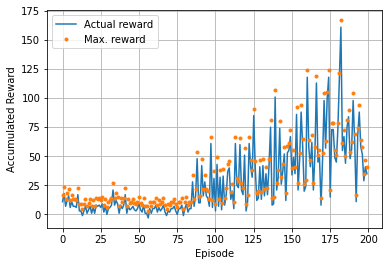

In [12]:
plt.plot(episode_reward, label='Actual reward')
plt.plot(max_reward, '.', label='Max. reward')
plt.xlabel('Episode')
plt.ylabel('Accumulated Reward')
plt.grid()
plt.legend()
plt.show()

In [13]:
max_reward

array([ 17.,  24.,  13.,  18.,  22.,  12.,  17.,  13.,  13.,  12.,  23.,
         9.,   9.,   5.,   9.,  13.,   7.,  10.,  13.,   7.,  12.,   7.,
        14.,  13.,  14.,  12.,  15.,   8.,  13.,   6.,  11.,  12.,  14.,
        27.,  14.,  18.,  15.,   7.,  14.,  11.,  14.,  23.,   7.,  13.,
        10.,  11.,  13.,  10.,   9.,  11.,  15.,  10.,   8.,  14.,   7.,
         7.,   3.,  11.,   7.,  11.,  11.,  14.,   8.,  12.,   9.,  11.,
        14.,   8.,   5.,   9.,   8.,  11.,  11.,  13.,   9.,   6.,  11.,
        11.,  14.,   5.,  11.,  15.,   8.,  11.,  11.,  34.,  13.,  22.,
        54.,  16.,  16.,  48.,  22.,  34.,  22.,  20.,  13.,  67.,  12.,
        37.,   9.,  49.,  13.,  38.,  10.,  39.,  14.,  23.,  43.,  46.,
        19.,  26.,  11.,  67.,  31.,  29.,  66.,  27.,  23.,  57.,   9.,
        17.,  67.,  47.,  38.,  91.,  46.,  18.,  20.,  47.,  19.,  48.,
        22.,  41.,  23.,  48.,  81.,  14.,  15., 107.,  27.,  38.,  80.,
        32.,  43.,  58.,  18.,  59.,  61.,  73.,  4

In [14]:
episode_reward

array([ 11.,  18.,   7.,  12.,  16.,   6.,  11.,   7.,   7.,   6.,  17.,
         3.,   3.,  -1.,   3.,   7.,   1.,   4.,   7.,   1.,   6.,   1.,
         8.,   7.,   8.,   6.,   9.,   2.,   7.,   0.,   5.,   6.,   8.,
        21.,   8.,  12.,   9.,   1.,   8.,   5.,   8.,  17.,   1.,   7.,
         4.,   5.,   7.,   4.,   3.,   5.,   9.,   4.,   2.,   8.,   1.,
         1.,  -3.,   5.,   1.,   5.,   5.,   8.,   2.,   6.,   3.,   5.,
         8.,   2.,  -1.,   3.,   2.,   5.,   5.,   7.,   3.,   0.,   5.,
         5.,   8.,  -1.,   5.,   9.,   2.,   5.,   5.,  28.,   7.,  16.,
        48.,  10.,  10.,  42.,  16.,  28.,  16.,  14.,   7.,  61.,   6.,
        31.,   3.,  43.,   7.,  32.,   4.,  33.,   8.,  17.,  37.,  40.,
        13.,  20.,   5.,  61.,  25.,  23.,  60.,  21.,  17.,  51.,   3.,
        11.,  61.,  41.,  32.,  85.,  40.,  12.,  14.,  41.,  13.,  42.,
        16.,  35.,  17.,  42.,  75.,   8.,   9., 101.,  21.,  32.,  74.,
        26.,  37.,  52.,  12.,  53.,  55.,  67.,  3

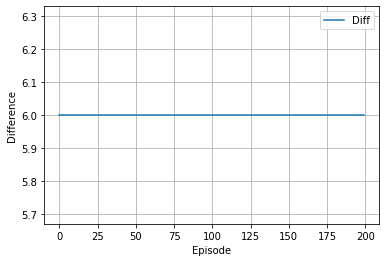

In [15]:
diff  = (max_reward - episode_reward)
plt.plot(diff, label='Diff')
plt.xlabel('Episode')
plt.ylabel('Difference')
plt.grid()
plt.legend()
plt.show()

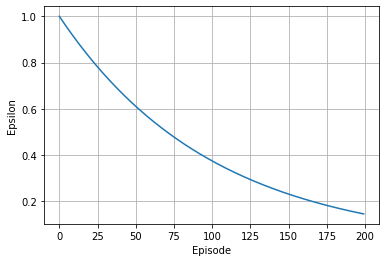

In [16]:
plt.plot(epsilon_vec)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid()
plt.show()

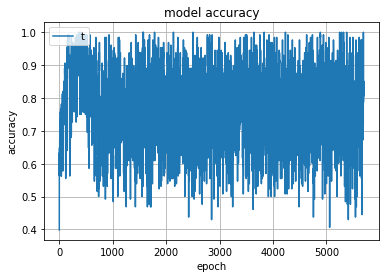

In [17]:
# summarize history for accuracy
plt.plot(acc_history)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.grid()
plt.show()

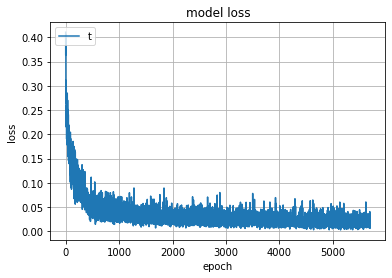

In [18]:
# summarize history for loss
plt.plot(loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.grid()
plt.show()